Here we derive an analytic and Monte Carlo (MC) models of the fraction of the coincident microbursts observed by both spacecraft vs. one assuming a fixed scale size.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy.optimize
import scipy.stats
import scipy.special
import time
from IPython.display import Image
import os

# import theano.tensor as tt
# import pymc3 as pm
import pandas as pd 
import progressbar

np.random.seed(123)

# Load and plot the CDF data

In [60]:
cdf_path = './../data/microburst_cdf_pdf_norm_v3.csv'
cdf_data = pd.read_csv(cdf_path)

In [61]:
cdf_data.head()

,Separation [km],CDF,PDF,CDF_std,PDF_std
0,0,1.000000,0.054516,0.064798,0.015809
1,5,0.727418,0.035251,0.045269,0.011236
2,10,0.551161,0.028598,0.033266,0.008033
3,15,0.408169,0.011309,0.022510,0.005884
4,20,0.351622,0.011795,0.018943,0.004858


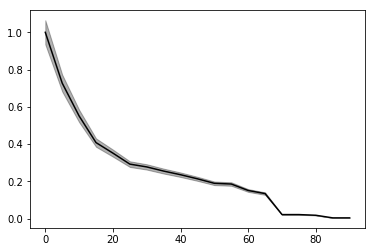

In [62]:
plt.fill_between(cdf_data['Separation [km]'], 
                 cdf_data['CDF']-cdf_data['CDF_std'], 
                 cdf_data['CDF']+cdf_data['CDF_std'], color='k', alpha=0.3);
plt.plot(cdf_data['Separation [km]'], cdf_data['CDF'], color='k');

# Develop a Monte Carlo model 
For development purposes we first assume a fixed microburst size. And generate n_bursts number of microbursts of size s and randomy scatter them on a grid of hight & width given by grid_size.

In [63]:
d = 40
grid_size = 200
n_bursts = int(1E5)
burst_size = np.random.uniform(d/2, d/2, size=n_bursts)
burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)

Visualize what the microbursts will look like on the grid.

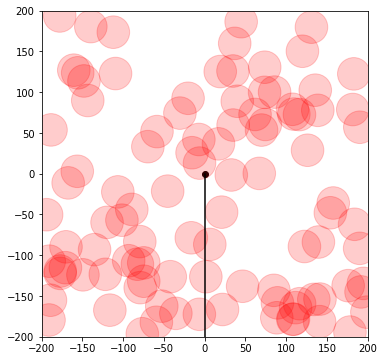

In [64]:
plot_n = 100
circles = plot_n*[None]
fig, ax = plt.subplots(figsize=(6, 6))

for c in range(plot_n):
    circles[c] = plt.Circle((burst_x[c], burst_y[c]), burst_size[c], color='r', alpha=0.2)
    ax.add_artist(circles[c])
plt.xlim(-grid_size, grid_size); plt.ylim(-grid_size, grid_size)
plt.scatter(0,0 , c='k')
plt.axvline(0, ymax=0.5, c='k')
ax.set_aspect(1.0)

Define a few helper functions to make the model look and run more smoothly

In [65]:
def dist(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [66]:
def circle_intersect(line_p, circle_p):
    """ 
    Returns true if a cicle defined by circle_p argument 
    defined as [center_x, center_y, radius] intersects a
    line defined as [x1, y1, x2, y2]. The line is assume 
    to be infinite in length. 
    
    Reference: http://mathworld.wolfram.com/Circle-LineIntersection.html
    """
    line_p[0] -= circle_p[0]; line_p[2] -= circle_p[0]
    line_p[1] -= circle_p[1]; line_p[3] -= circle_p[1]
    dx = line_p[2] - line_p[0]
    dy = line_p[3] - line_p[1]
    dr = np.sqrt(dx**2 + dy**2)
    D = line_p[0]*line_p[3] - line_p[2]*line_p[1]
    if circle_p[2]**(2)*dr**2 - D**2 >= 0:
        return True
    else:
        return False

Define the a few MC funcitons to tally the microburst events. They are mainly here to explore different tallying algorithms.

In [81]:
def mc_brute_force(d, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    Brute force method that is computationally slow
    but should be the closest to reality
    """
    N = np.zeros_like(bins)
    
    # If supplied a single valued diameter d.
    if not hasattr(d, '__len__'):
        d = d*np.ones(n_bursts)
    
    for i, bin_i in enumerate(bins):
        # Generate n_bursts number of microbursts randomly scattered in a grid
        # and fixed radius r.
        burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
        burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
        
        # Now loop over the bursts and tally up the number of microbursts 
        # observed by hypothetical spacercaft at (0, 0) and (0, bin_i).
        for bx, by, bd in zip(burst_x, burst_y, d):
            if (dist(bx, by, 0, 0) <= bd/2) and (dist(bx, by, 0, bin_i) <= bd/2): 
                N[i] += 1
    total_N = np.sum(N)
    cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
    return cdf

def cdf_simpler(d, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    This function tallies events that were see by both spacercaft over 
    the events seen by one, or both spacercaft as a function of spacecraft separation.
    """
    n = np.zeros(len(bins))
    
    burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    
    # Loop over the spacecraft separations.
    for i, d in enumerate(bins):
        # Loop over the microbursts.
        for bx, by in zip(burst_x, burst_y):
            # Skip if the circle did not intersect the y-axis 
            # (not going to be seen by either spacecraft).
            if not circle_intersect([0, 0, 0, 10], [bx, by, d/2]):
                continue
            # Both see it
            if dist(bx, by, 0, d) <= d/2 and dist(bx, by, 0, 0) <= d/2: 
                n[i] += 1
    total_detected = np.sum(n)
    cdf = np.array([np.sum(n[i:])/total_detected for i in range(len(n))])
    return cdf

def cdf_brute_vectorized(burst_diamaters, n_bursts=100000, 
                         bins=np.arange(0, 100, 5), 
                         grid_size=200):
    """ 
    This function tallies events that were see by both spacercaft over 
    the events seen by one, or both spacercaft as a function of spacecraft 
    separation.
    """
    n = np.zeros(len(bins))
    
    # If supplied a single-valued diameter burst_diamaters. If supplied an array, 
    # I implicityly assume the diameters are distributed according to 
    # some PDF distribution.
    if not hasattr(burst_diamaters, '__len__'):
        burst_diamaters = burst_diamaters*np.ones(n_bursts)
    # Randomly generate n_burst microburst centers.
    burst_centers = np.random.uniform(-grid_size, grid_size, size=(n_bursts, 2))
    
    ### Calculate which bursts interesect the origin. ###
    # First calculate the distance each burst is from the origin
    spacecraft_location = np.zeros_like(burst_centers)
    distance_to_origin = np.linalg.norm(burst_centers-spacecraft_location, axis=1)
    # Where close_to_origin is True, the microburst intersected the origin.
    # We only need to loop over the True values.
    close_to_origin = np.less(distance_to_origin, burst_diamaters/2)
    i_close_to_origin = np.where(close_to_origin)[0]
    # Filter the burst centers to loop over only the ones that contain the origin.
    burst_centers = burst_centers[i_close_to_origin, :]
    burst_diamaters = burst_diamaters[i_close_to_origin]
    
    # Loop over all spacecraft bins and calculate the subset of the microbursts
    # that contain the origin also contain the spacecraft at distance d from the
    # origin along one axis (positive y-axis in this model).
    for i, d in enumerate(bins):
        spacecraft_location = np.zeros_like(burst_centers)
        spacecraft_location[:, 1] = d
        distance_to_spacecraft = np.linalg.norm(burst_centers-spacecraft_location, 
                                            axis=1)
        # Where close_to_origin is True, the microburst intersected the origin.
        # We only need to loop over the True values.
        close_to_spacecraft = np.less(distance_to_spacecraft, burst_diamaters/2)
        n[i] = np.sum(close_to_spacecraft)
    total_detected = np.sum(n)
    cdf = np.array([np.sum(n[i:])/total_detected for i in range(len(n))])
    return cdf

def mc_tally_analytic(d, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    This implements an MC model with an analytic tally. Benefit of this method
    is that it only has to loop through the microbursts once.
    """
    # Generate n_bursts number of microbursts randomly scattered in a grid
    # and diameter d.
    burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    
    if not hasattr(d, '__len__'):
        d = d*np.ones(n_bursts)
    
    N = np.zeros_like(bins)
    for bx, by, bd in zip(burst_x, burst_y, d):
        # Since microburst was seen at the origin, see how far away another 
        # spacecraft would have seen it.
        if (dist(bx, by, 0, 0) <= bd/2):
            # Since microburst was seen at the origin, find the max distance
            # it would have been observed away from the origin.
            y_max = by + np.sqrt((bd/2)**2 - bx**2)
            # All bin indicies less than y_max
            sc_idx = np.where(bins <= y_max)[0] 
            N[sc_idx] += 1
    total_N = np.sum(N)
    cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
    return cdf

# Validate different MC versions against each other
to make sure we are correctly counting microbursts to compare to the data and that all of the models work as expected

In [68]:
bins = np.arange(0, 100, 5)
start_time = time.time()
cdf_brute = mc_brute_force(d, bins=bins)
print(f'MC brute force run time {round(time.time()-start_time, 2)} s')

MC brute force run time 7.61 s


In [69]:
start_time = time.time()
mc_brute_vectorized = cdf_brute_vectorized(d, bins=bins)
print(f'MC vectorized run time {round(time.time()-start_time, 2)} s')

MC vectorized run time 0.02 s


In [70]:
start_time = time.time()
mc_cdf = cdf_simpler(d, bins=bins)
print(f'MC simpler run time {round(time.time()-start_time, 2)} s')

MC simpler run time 13.1 s


/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


In [71]:
start_time = time.time()
cdf_tally_analytic = mc_tally_analytic(d, bins=bins)
print(f'MC with analytic tally run time {round(time.time()-start_time, 2)} s')

MC with analytic tally run time 0.4 s


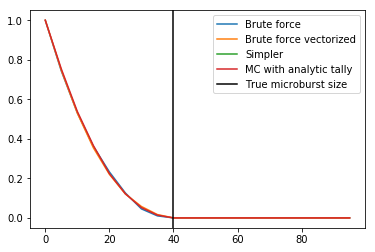

In [72]:
plt.plot(bins, cdf_brute, label='Brute force')
plt.plot(bins, mc_brute_vectorized, label='Brute force vectorized')
plt.plot(bins, mc_cdf, label='Simpler');
plt.plot(bins, cdf_tally_analytic, label='MC with analytic tally');
plt.axvline(d, color='k', label='True microburst size');
plt.legend();

# Analytic Microburst Scale Size Model

Here is the geometric model of the problem. The diagram below shows two spacecraft as blue cubes, separated by some distance $d$. Now imagine an extreme case of a microburst ofradius $r$ that is the furthest distance from both spacecraft and still observed by both. These microbursts are left-right symmetric and the distance between the microburst centers and the two spacecraft is $r$. This case is shown with two black circles. The center of both black circles is marked with a black dot.

In the current configuration the microburst will be observed by both spacecraft. Equilantly, microbursts with centers closer to the origin than the current microburst centers will also be observed by both spacecraft. These new points imply that there is an infinite family of microburst centers for which a microburst will be observed by both spacecraft as a function of $d$ and $r$. Our goal is to quantify this by calculating the area $A(r, d)$ in which a microburst center will be observed by both spacecraft.

Observe that if you take the origional geometry and rotate the right circle clockwise about the top spacecraft, its origin will trace out a curve that connects the two black circle centers which is shown by the lower red-dotted line. This problem is symmetric and we can also rotate the right circle counter-clockwise about the lower spacecraft and trace out an upper red-dotted curve. Now if a microburst center lies anywhere in the area bounded by the red-dotted curves, it will encompass both spacecraft.

How do we find $A(r, d)$? Imagine that instead of just tracing out the red-dotted curves, we continue rotating the circles for a rull revolution. This will trace out a second set of circles shown with a solid red curve. These circles have a radius $r$ as before, and they are separated by a distance d. Now if $d \lt 2r$ the circles will intersect and the area we want is just the circle-intersection area 
(<a class="reference external" href="http://mathworld.wolfram.com/Circle-CircleIntersection.html">Wolfram</a>)

\begin{equation}
A(r, d) = 2r^2 \cos^{-1}{\Big( \frac{d}{2r} \Big)} - \frac{d}{2} \sqrt{4r^2 - d^2}
\end{equation}

Lastly we calculate the microburst CDF. Compare the number of microbursts of size $r$ that would be observed by both spacecraft at a spacecraft separation $d_0$ and $d_1$ with $d_0 < d_1$. The fraction of the number of microbursts observed at $d_1$ compared to $d_0$ is just the fraction of the areas since microbursts are uniformly distributed around the two spacecraft. Now we can compare these areas to the CDF derived from the data. For now assume a fixed microburst scale size, and a range of separations $D$. Then 

\begin{equation}
CDF(r, D) = \frac{\sum_{d > D} A(r, d)}{\sum_{d \in D} A(r, d)}
\end{equation}.

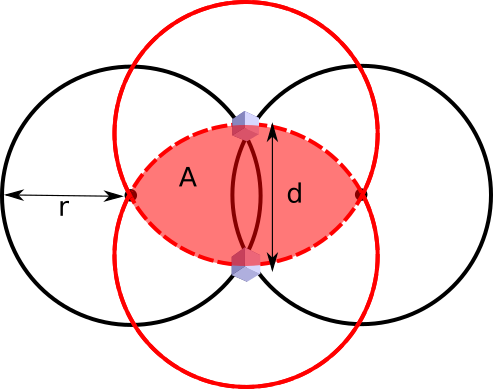

In [73]:
Image("analytic_coincident_microburst_scale_size_bounds.png", width=400)

In [74]:
A = lambda diameter, d: 2*(diameter/2)**2*np.arccos(d/(diameter)) - d/2*np.sqrt(diameter**2 - d**2)
F = lambda diameter, d: np.array([np.nansum(A(diameter, d[i:]))/np.nansum(A(diameter, d)) for i in range(len(d))])   #A1(r, d)/(2*np.pi*r**2 - A1(r, d))

Visualize the Analytical CDFs for a fixed-sized microburst

/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


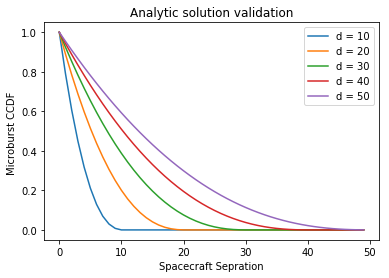

In [75]:
sc_bins = np.arange(50)
test_d = np.arange(10, 51, 10)
#plt.figure(figsize=(10, 6))

for d_i in test_d:
    plt.plot(sc_bins, F(d_i, sc_bins), label=f'd = {d_i}');
plt.legend();
plt.xlabel('Spacecraft Sepration'); plt.ylabel('Microburst CCDF '); 
plt.title('Analytic solution validation');

# Validation of the MC vs Analytic models
Here I assume that all microbursts are the same size and check if the MC and the analytical models give the same result. I will then generalize the analytic model to make a CDF assuming some scale size PDF and not one value.

In [76]:
start_time = time.time()
cdf_analytic = F(d, bins)
print(f'Analytic MC run time {round(time.time()-start_time, 5)}')

Analytic MC run time 0.00304


/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


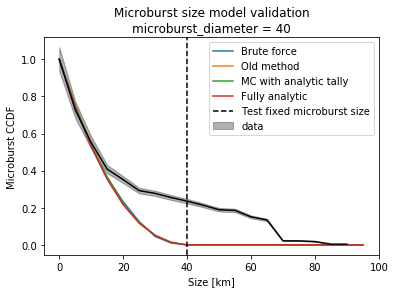

In [77]:
plt.plot(bins, cdf_brute, label='Brute force')
plt.plot(bins, mc_cdf, label='Old method');
plt.plot(bins, cdf_tally_analytic, label='MC with analytic tally');
plt.plot(bins, cdf_analytic, label='Fully analytic')
plt.plot(cdf_data['Separation [km]'], cdf_data['CDF'], c='k', label='_nolegend_')
plt.fill_between(cdf_data['Separation [km]'], 
                 cdf_data['CDF']-cdf_data['CDF_std'], 
                 cdf_data['CDF']+cdf_data['CDF_std'], 
                 color='k', alpha=0.3, label='data');
plt.axvline(d, color='k', ls='--', label='Test fixed microburst size');
plt.legend(); plt.xlim(right=100);
plt.title(f'Microburst size model validation\nmicroburst_diameter = {d}');
plt.xlabel('Size [km]'); plt.ylabel('Microburst CCDF');
#plt.savefig('compare_mc_models.png', dpi=300)

# Now try a combination of two microburst populations
Assume a fixed-size microburst PDF of the form $\mathrm{pdf}(d, a, x) = a \delta(d_0 - x) + (1-a) \delta(d_1 - x)$ where $\delta(x)$ is the Dirac delta function, $a$ is the mixing parameter, $d$ is the two scale sizes, and x is the bin independent variable.

In [78]:
bins = np.arange(0, 130, 5)
a = 0.99 #0.99
d = np.array([20, 120]) # [20, 120]

In [82]:
r_array = np.random.choice(d, size=int(1E5), p=[a, (1-a)])
cdf_brute_two_population = mc_brute_force(r_array, n_bursts=int(1E5), bins=bins)
cdf_vectorized_two_population = cdf_brute_vectorized(r_array, n_bursts=int(1E5), bins=bins)

In [83]:
def analytic_cdf_two_population(a, d, bins):
    total_events = a*np.nansum(A(d[0], bins)) + (1-a)*np.nansum(A(d[1], bins))
    cdf =  np.array([(a*np.nansum(A(d[0], bins[i:])) + (1-a)*np.nansum(A(d[1], bins[i:])))/total_events 
                      for i in range(len(bins))])
    return cdf

/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


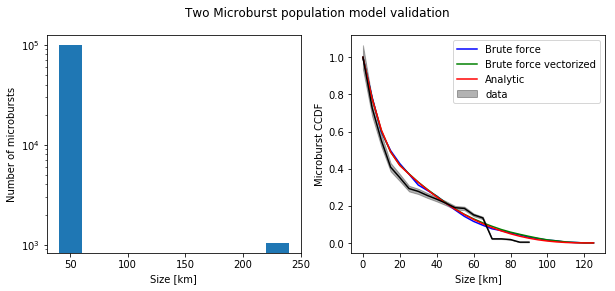

In [84]:
b = 0.99
_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(2*r_array, density=False)
ax[1].plot(bins, cdf_brute_two_population, c='b', label='Brute force');
ax[1].plot(bins, cdf_vectorized_two_population, c='g', 
           label='Brute force vectorized');
ax[1].plot(bins, analytic_cdf_two_population(a, d, bins), c='r', label='Analytic');
ax[1].plot(cdf_data['Separation [km]'], cdf_data['CDF'], c='k', label='_nolegend_')
ax[1].fill_between(cdf_data['Separation [km]'], 
                 cdf_data['CDF']-cdf_data['CDF_std'], 
                 cdf_data['CDF']+cdf_data['CDF_std'], 
                 color='k', alpha=0.3, label='data');            
ax[0].set(yscale='log', xlabel='Size [km]', ylabel='Number of microbursts')
ax[1].set(xlabel='Size [km]', ylabel='Microburst CCDF')
plt.suptitle('Two Microburst population model validation');
ax[1].legend();

# Generalize these model to use a Maxwell microburst PDF

In [23]:
lognorm_mean=np.log(40); lognorm_sigma=0.5

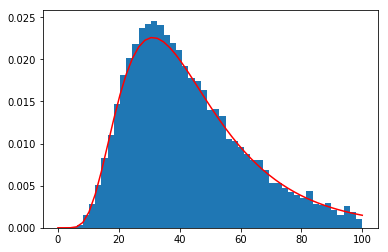

In [24]:
lognorm_rv = np.random.lognormal(mean=lognorm_mean, sigma=lognorm_sigma, size=10000)
plt.hist(lognorm_rv, bins=np.linspace(0, 100), density=True);

# Check against scipy's implementation
#help(scipy.stats.lognorm)
lognorm = scipy.stats.lognorm(scale=np.exp(lognorm_mean), s=lognorm_sigma)
plt.plot(np.linspace(0, 100), lognorm.pdf(np.linspace(0, 100)), c='r');

Specialize these MC and analytic functions to generate microbursts according to a microburst log normal PDF.

In [72]:
def mc_brute_force_lognorm(mean, sigma, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    Brute force method that is computationally slow
    but should be the closest to reality
    """
    N = np.zeros_like(bins)
    for i, bin_i in enumerate(bins):
        # Generate n_bursts number of microbursts randomly scattered in a grid
        # and fixed radius r.
        burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
        burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
        burst_r = np.random.lognormal(mean=mean, sigma=sigma, size=n_bursts)
        
        # Now loop over the bursts and tally up the number of microbursts 
        # observed by hypothetical spacercaft at (0, 0) and (0, bin_i).
        for bx, by, br in zip(burst_x, burst_y, burst_r):
            if (dist(bx, by, 0, 0) <= br) and (dist(bx, by, 0, bin_i) <= br): 
                N[i] += 1
    total_N = np.sum(N)
    cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
    return cdf

def mc_tally_analytic_lognorm(mean, sigma, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    This implements an MC model with an analytic tally. Benefit of this method
    is that it only has to loop through the microbursts once.
    """
    # Generate n_bursts number of microbursts randomly scattered in a grid
    # and fixed radius r.
    burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_r = np.random.lognormal(mean=mean, sigma=sigma, size=n_bursts)
    
    N = np.zeros_like(bins)
    for bx, by, br in zip(burst_x, burst_y, burst_r):
        # Since microburst was seen at the origin, see how far away another 
        # spacecraft would have seen it.
        if (dist(bx, by, 0, 0) <= br):
            # Since microburst was seen at the origin, find the max distance
            # it would have been observed away from the origin.
            y_max = by + np.sqrt(br**2 - bx**2)
            # All bin indicies less than y_max
            sc_idx = np.where(bins <= y_max)[0] 
            N[sc_idx] += 1
    total_N = np.sum(N)
    cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
    return cdf

def analytic_cdf_two_population(a, d, bins):
    total_events = a*np.nansum(A(d[0], bins)) + (1-a)*np.nansum(A(d[1], bins))
    cdf =  np.array([(a*np.nansum(A(d[0], bins[i:])) + (1-a)*np.nansum(A(d[1], bins[i:])))/total_events 
                      for i in range(len(bins))])
    return cdf

def analytic_model_dist(dist, dist_kwargs, sc_bins=np.arange(100), 
                        microburst_scales=np.arange(1000)):
    """
    Assuming a distribution for the microburst scale size, 
    calculate the microburst CDF at spacecraft separations 
    given by sc_bins kwarg. The contirbutions of 
    microbursts of sizes defined by the microburst_scales
    kwarg is considered here, and is superposed and weighted
    by their relative proibability of occuring as defined
    by the scale size Gaussian PDF.
    """
    # Assuming a distribution, calculate the probability of 
    # seeing a microburst of all sizes in microburst_scales.
    microburst_cdf = dist(**dist_kwargs).cdf(microburst_scales)
    weights = microburst_cdf[1:] - microburst_cdf[:-1]
    total_events = np.sum([w_i*np.nansum(A(d_i, sc_bins)) 
                           for w_i, d_i in zip(weights, 
                                               microburst_scales[:-1])])

    spacecraft_cdf = np.nan*np.zeros((len(sc_bins), len(microburst_scales[:-1])))    
    # Loop over spacecraft separations
    for i in range(len(spacecraft_cdf)):
        # Loop over each microburst size, and scale each CDF by weight.
        for j, (w_i, d_i) in enumerate(zip(weights, microburst_scales[:-1])):
            spacecraft_cdf[i, j] = w_i*np.nansum(A(d_i, sc_bins[i:]))
            
#         spacecraft_cdf[i] = np.sum([w_i*np.nansum(A(d_i, sc_bins[i:])) 
#                             for w_i, d_i in zip(weights, 
#                                                microburst_scales[:-1])])
    spacecraft_cdf = np.sum(spacecraft_cdf, axis=1)
    return spacecraft_cdf/total_events

In [73]:
lognorm_sc_bins = np.linspace(0, 300)
start_time = time.time()
#cdf_brute_lognorm = mc_brute_force_lognorm(lognorm_mean, lognorm_sigma, n_bursts=n_bursts, bins=lognorm_sc_bins)
print(f'Brute force MC run time {round(time.time()-start_time, 5)}')
start_time = time.time()
cdf_analytic_tally_lognorm = mc_tally_analytic_lognorm(lognorm_mean, lognorm_sigma, n_bursts=n_bursts, bins=lognorm_sc_bins)
print(f'MC with analytic tally run time {round(time.time()-start_time, 5)}')
cdf_analytic = analytic_model_dist(scipy.stats.lognorm, 
                                   {'scale':np.exp(lognorm_mean), 's':lognorm_sigma}, 
                                   sc_bins=lognorm_sc_bins)
#cdf_true = 1-(0.5+0.5*scipy.special.erf((np.log(bins) - np.exp(lognorm_mean))/(np.sqrt(2)*lognorm_sigma)))

Brute force MC run time 3e-05
MC with analytic tally run time 0.39281


/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


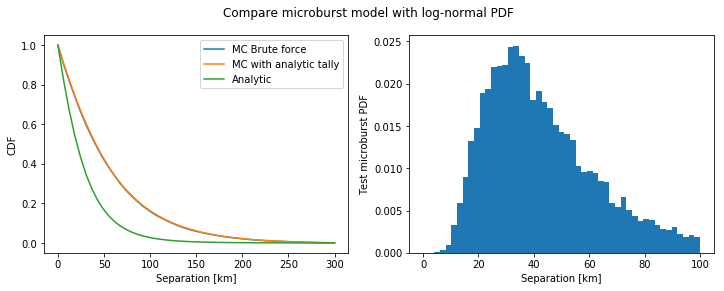

In [74]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(lognorm_sc_bins, cdf_brute_lognorm, label='MC Brute force')
ax[0].plot(lognorm_sc_bins, cdf_analytic_tally_lognorm, label='MC with analytic tally');
ax[0].plot(lognorm_sc_bins, cdf_analytic, label='Analytic')
ax[0].legend(); plt.suptitle('Compare microburst model with log-normal PDF');
ax[0].set_xlabel('Separation [km]'); ax[0].set_ylabel('CDF');

lognorm_rv = np.random.lognormal(mean=lognorm_mean, sigma=lognorm_sigma, size=10000)
H, _ = np.histogram(lognorm_rv, bins=np.linspace(0, 100), density=False)
ax[1].hist(lognorm_rv, bins=np.linspace(0, 100), density=True);
ax[1].set(xlabel='Separation [km]', ylabel='Test microburst PDF');

So it looks like the analytic solution does not quite agree with the MC models. Need to check the area expression with http://mathworld.wolfram.com/Circle-CircleIntersection.html

# Finding PDF parameters with MCMC
Now I Use the pymc3 library to calculate the range of most probable microburst PDF parameters that fit the data CDF well assuming a noise model and a parametrtic PDF. 

In [30]:
# def mc_tally_analytic_tt(r, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
#     """ 
#     This implements an MC model with an analytic tally. Benefit of this method
#     is that it only has to loop through the microbursts once.
#     """
#     # Generate n_bursts number of microbursts randomly scattered in a grid
#     # and fixed radius r.
#     burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
#     burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    
#     N = np.zeros_like(bins)
#     for bx, by in zip(burst_x, burst_y):
#         # Since microburst was seen at the origin, see how far away another 
#         # spacecraft would have seen it.
#         if dist(bx, by, 0, 0) <= r:
#             # Since microburst was seen at the origin, find the max distance
#             # it would have been observed away from the origin.
#             y_max = by + np.sqrt(r**2 - bx**2)
#             # All bin indicies less than y_max
#             sc_idx = np.where(bins <= y_max))[0] 
#             N[sc_idx] += 1
#     total_N = np.sum(N)
#     cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
#     return cdf

# sigma = 0.5
# with pm.Model() as m:
#     rr = pm.Uniform('r', 0, 100, shape=2)
#     print(rr.eval())
#     cdf = mc_tally_analytic_tt(rr.eval()[0])
#     print(cdf)
#     cdf_obs = pm.Normal('cdf_obs', mu=cdf, sd=sigma, observed=cdf_data['CDF'])
#     #trace = pm.sample()
# pm.find_MAP(model=m)

In [47]:
def metroplis(start, target, proposal, niter, nburn=0, 
            thin=1, verbose=False):
    """
    This function implements the Metropolis–Hastings sampler.
    """
    niter = int(niter)
    current = start
    post = -1E31*np.ones((niter, len(start)), dtype=float)

    for i in progressbar.progressbar(range(niter)):
        if verbose:
            print('MCMC progress {} %'.format(round(100*i/niter)))
        proposed = proposal(current)
        p = min(target(proposed)/target(current), 1)
        if np.random.random() < p:
            current = proposed
        post[i, :] = current
    return post[int(nburn)::thin, :]

def Likelihood(p, x, y, mode='analytic'):
    """ Gaussian likelihood. """
    C = (np.std(y)*np.sqrt(2*np.pi))
    if mode == 'analytic':
        y_model = F(p[0], x)
    else:
        y_model = mc_brute_force(p[0], bins=x)
    args = sum([(y_i - y_model_i)**2 
                for (y_i, y_model_i) in zip(y, y_model)])
    return np.exp(-0.5*args/np.var(y))/C

Specifiy this MCMC run

In [73]:
savePath = ('/home/mike/research/ac6_microburst_scale_sizes/models/mcmc_traces'
            '/mc_trace_single_r.csv')
if os.path.exists(savePath):
    raise ValueError('Data already saved. Use a different savePath. Aborting.')
    
# Specify priors for the one fixed-sized microburst model.
prior = [scipy.stats.uniform(0, 100)]
# Initial guess on the microburst size.
start = [prior_i.rvs(random_state=0) for prior_i in prior]
# How much to jump
proposal_jump = 2
proposal = lambda p: [scipy.stats.norm(loc=p_i, scale=proposal_jump).rvs() 
                      for p_i in p]
# The target function. If probability is higher, take the new value given from proposal. 
# Else do the Metroplis thing where you draw a random number between 0 and 1 and compare
# to the target value (which will be less than 1).
target = lambda p: Likelihood(p, cdf_data['Separation [km]'], 
                              cdf_data['CDF'], mode='mc')*np.prod(
                              [prior_i.pdf(p) for prior_i, p_i in zip(prior, p)])
niter = 1000
trace = metroplis(start, target, proposal, niter, 
                        nburn=100, thin=1, verbose=False)
# Save data
df = pd.DataFrame(data=trace, columns=['r0'])
df.to_csv(savePath, index=False)

100% (1000 of 1000) |####################| Elapsed Time: 2:35:08 Time:  2:35:08


In [74]:
r_mean = np.mean(trace)
r_credible_interval = np.percentile(trace, [2.5, 97.5])

In [75]:
print(f'mean = {r_mean} | 95% CI = {r_credible_interval}')

mean = 36.39112410480695 | 95% CI = [10.75869305 71.12679019]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


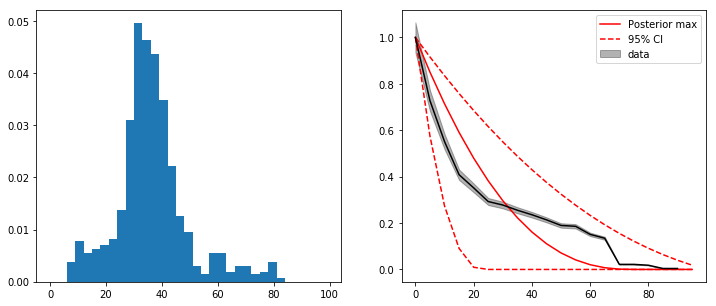

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(trace, bins=np.arange(0, 100, 3), density=True);
ax[1].plot(bins, F(r_mean, bins), 'r', label='Posterior max');
ax[1].plot(bins, F(r_credible_interval[0], bins), 'r--', label='95% CI');
ax[1].plot(bins, F(r_credible_interval[1], bins), 'r--');
ax[1].plot(cdf_data['Separation [km]'], cdf_data['CDF'], c='k', label='_nolegend_')
ax[1].fill_between(cdf_data['Separation [km]'], 
                 cdf_data['CDF']-cdf_data['CDF_std'], 
                 cdf_data['CDF']+cdf_data['CDF_std'], 
                 color='k', alpha=0.3, label='data');
ax[1].legend();